<a href="https://colab.research.google.com/github/tanvikurade/Word2Vec-from-scratch/blob/main/word2vecfromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** For developing word2vec model from scratch we need some libraries so let's import required libraries.**


In [1]:
import json
import pandas as pd
import string
import time

There's amazing dataset of Amazon musical instruments reviews. So let's read the data. [link text](https://www.kaggle.com/eswarchandt/amazon-music-reviews?select=Musical_instruments_reviews.csv)

In [2]:
#Create dataframe and read the data.
data = pd.DataFrame()
data = pd.read_csv('Musical_instruments_reviews.csv', encoding='utf-8')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
df= data 

In [4]:
#let's drop the columns which aren't necessary.
df = df.drop(columns=['reviewerName'])
df1 = df.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [5]:
#for building our model we need only rating and reviews so let's keep them and drop other columns.
df1.dropna(axis = 0, how ='any',inplace=True) 
df1.drop_duplicates(subset=['rating','reviewText'],keep='first',inplace=True)

In [6]:
#To clean the text, remove punctuation and create list of words for every input text.
def clean_text(text ): 
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [7]:
#let's create subsample of 2000 reviews, so that every review is now converted to list of words via clean text method.
df2 = df1.sample(n=2000)
df2['reviewText']= df2['reviewText'].apply(clean_text)

In [8]:
sentences = df2['reviewText'].tolist()

print(len(sentences))
print(sentences[1])
print(sentences[200])

2000
['they', 'the', 'job', 'great', 'not', 'bad', 'price', 'for', 'many', 'you', 'getgoing', 'buy', 'some', 'more', 'for', 'sure']
['you', 'just', 'spent', 'all', 'your', 'money', 'guitar', 'and', 'not', 'want', 'spend', 'much', 'more', 'accessorizing', 'this', 'strap', 'perfect', 'even', 'you', 'have', 'the', 'money', 'spend', 'and', 'just', 'looking', 'for', 'something', 'that', 'will', 'the', 'job', 'well', 'the', 'materials', 'are', 'high', 'quality', 'soft', 'nylon', 'for', 'the', 'strap', 'feels', 'kind', 'like', 'non', 'stretch', 'ace', 'bandage', 'durable', 'non', 'scratching', 'marring', 'plastic', 'for', 'the', 'links', 'and', 'adjuster', 'and', 'thick', 'rubber', 'material', 'for', 'the', 'ends', 'the', 'thickness', 'rubber', 'material', 'for', 'the', 'end', 'secure', 'the', 'the', 'straps', 'pretty', 'well', 'they', 'not', 'slide', 'the', 'strap', 'pegs', 'very', 'easily', 'say', 'rubber', 'like', 'because', 'they', 'seem', 'more', 'like', 'synthetic', 'leather', 'but', 'w

In [9]:
import gensim

In [10]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [11]:
# init word2vec class (Skip-Gram Model)
w2v_model = Word2Vec(size = 300,
                     window = 15,
                     min_count = 2,
                     workers = 20,
                     sg = 1,
                     negative = 5,
                     sample = 1e-5)
# build vovab


w2v_model.build_vocab(sentences)

  
# train the w2v model
start = time.time()
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=1001, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsedtime in seconds :"+ str(end - start))
# save the word2vec model
w2v_model.save('/content/Musical_instruments_reviews\\word2vec.model')

Loss after epoch 0: 69621.8828125
Loss after epoch 100: 24566.5
Loss after epoch 200: 22044.0
Loss after epoch 300: 23549.0
Loss after epoch 400: 23533.0
Loss after epoch 500: 18704.0
Loss after epoch 600: 18937.0
Loss after epoch 700: 20850.0
Loss after epoch 800: 18426.0
Loss after epoch 900: 19026.0
Loss after epoch 1000: 14806.0
elapsedtime in seconds :336.02653789520264


In [12]:
#Let's reload our w2v model and perform some operations.
reloaded_w2v_model = Word2Vec.load('/content/Musical_instruments_reviews\\word2vec.model')
words = list(reloaded_w2v_model.wv.vocab)
print('Vocab size: '+str(len(words)))
w1 = 'clamping'
print("Top 3 words similar to clamping:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn =3))
w1 = 'bullet'
print("Top 3 words similar to bullet:",\
      reloaded_w2v_model.wv.most_similar(positive = w1,topn =3))
print("Similarity between strings and guitar:"+\
      str(reloaded_w2v_model.wv.similarity(w1="strings",w2="guitar")))
print("Similarity between sound and quality:"+\
      str(reloaded_w2v_model.wv.similarity(w1="sound",w2="quality")))

Vocab size: 4854
Top 3 words similar to clamping: [('meow', 0.5979235172271729), ('artists', 0.5843032598495483), ('stretches', 0.5822824239730835)]
Top 3 words similar to bullet: [('250s', 0.6324681043624878), ('capacitance', 0.5412150621414185), ('unlatched', 0.5151268243789673)]
Similarity between strings and guitar:0.41765982
Similarity between sound and quality:0.3591727


In [13]:
#Let's use TSNE to reduce dimesions, and try to visualize.
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(reloaded_w2v_model)

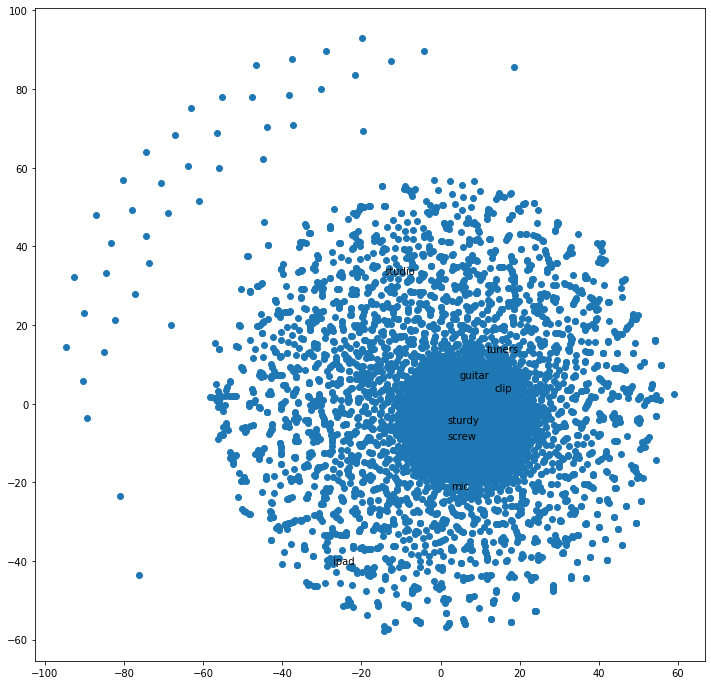

In [14]:
#let's plot the data.
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    
    # Label randomly subsampled 25 data points
    
    
    
    indices = list(range(len(labels)))
    #selected_indices = random.sample(indices, 25)
    selected_indices=[]
    index = labels.index("clip")
    selected_indices.append(index)
    index = labels.index("ipad")
    selected_indices.append(index)
    index = labels.index("sturdy")
    selected_indices.append(index)
    index = labels.index("mic")
    selected_indices.append(index)
    index = labels.index("guitar")
    selected_indices.append(index)
    index = labels.index("studio")
    selected_indices.append(index)
    index = labels.index("screw")
    selected_indices.append(index)
    index = labels.index("tuners")
    selected_indices.append(index)
    
    
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))



plot_function = plot_with_matplotlib

plot_function(x_vals, y_vals, labels)

**So it can be concluded that our model is working properly as we can see  studio, guitar also clip, tuners and screw are really close to each other in this vector space**